✅ Validation set saved as 'X_val.npy'
Epoch 1/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 572ms/step - accuracy: 0.6237 - loss: 0.7553 - val_accuracy: 0.5367 - val_loss: 0.7829 - learning_rate: 5.0000e-04
Epoch 2/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 539ms/step - accuracy: 0.8535 - loss: 0.3961 - val_accuracy: 0.5033 - val_loss: 1.0702 - learning_rate: 5.0000e-04
Epoch 3/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.8852 - loss: 0.2692 - val_accuracy: 0.5133 - val_loss: 0.8541 - learning_rate: 5.0000e-04
Epoch 4/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 539ms/step - accuracy: 0.9171 - loss: 0.2071 - val_accuracy: 0.5333 - val_loss: 1.3726 - learning_rate: 5.0000e-04
Epoch 5/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.9196 - loss: 0.1982 - val_accuracy: 0.6700 - val_loss: 0.6382 - learning_rate: 5.0000e-04
Epoch 6/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.9263 - loss: 0.1978 - val_accuracy: 0.5433 - val_loss: 1.3770 - learning_rate: 5.0000e-04
Epoch 7/60
44/44 ━━━

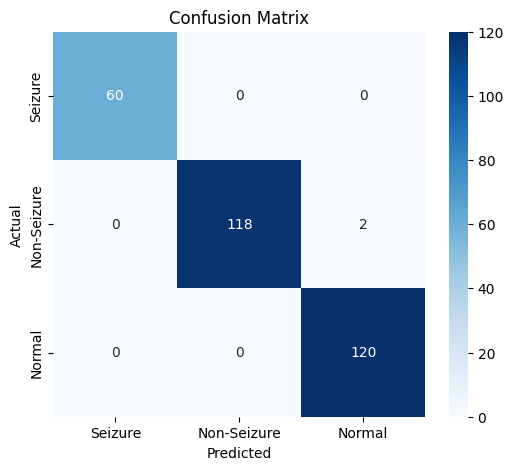

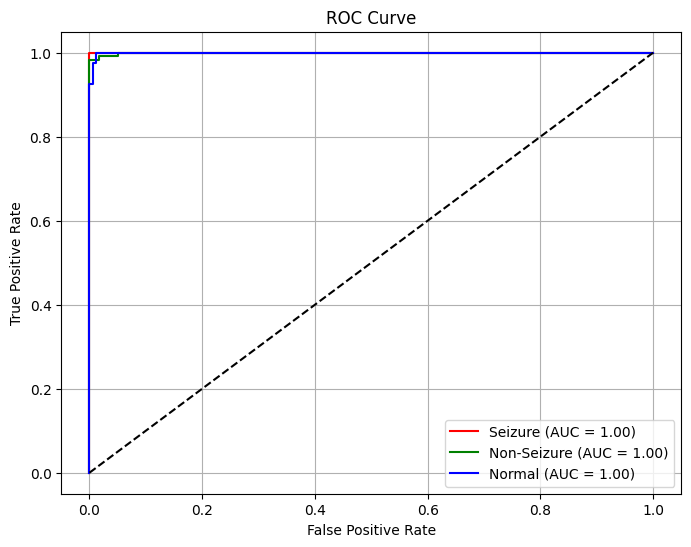

In [ ]:
# 📦 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Add, GlobalAveragePooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# 🧠 Load and label EEG data
def load_data():
    files = {
        '/content/epilepsy_with_seizure_data.xlsx': 0,
        '/content/epilepsy_without_seizure_data.xlsx': 1,
        '/content/normal_data.xlsx': 2
    }
    all_data, all_labels = [], []
    for file, label in files.items():
        df = pd.read_excel(file)
        for content in df['Content']:
            signal = np.array([float(x) for x in str(content).split('\n') if x.strip()])
            all_data.append(signal)
            all_labels.append(label)
    return np.array(all_data, dtype=object), np.array(all_labels)

# 🔄 Data augmentation
def augment_signal(signal):
    noise = np.random.normal(0, 0.01, len(signal))
    signal_jittered = signal + noise
    scale_factor = np.random.uniform(0.9, 1.1)
    signal_scaled = signal * scale_factor
    flipped = signal[::-1]
    return [signal, signal_jittered, signal_scaled, flipped]

# 🧹 Preprocess signals
def preprocess(data, labels):
    max_len = max(len(d) for d in data)
    X_aug, y_aug = [], []
    for signal, label in zip(data, labels):
        for aug in augment_signal(signal):
            padded = np.pad(aug, (0, max_len - len(aug)), 'constant')
            X_aug.append(padded)
            y_aug.append(label)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aug)
    return np.array(X_scaled), np.array(y_aug), scaler

# 🔁 Reshape to 2D
def reshape_2d(X, size=(64, 64)):
    reshaped = []
    for signal in X:
        target_len = size[0] * size[1]
        if len(signal) > target_len:
            signal = signal[:target_len]
        elif len(signal) < target_len:
            signal = np.pad(signal, (0, target_len - len(signal)), mode='constant')
        reshaped.append(signal.reshape(size))
    return np.expand_dims(np.array(reshaped), axis=-1)

# 🧱 Residual Block
def residual_block(x, filters):
    shortcut = Conv2D(filters, (1, 1), padding='same')(x)
    shortcut = BatchNormalization()(shortcut)
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# 🏗️ Build Deep Residual CNN
def build_advanced_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, 32)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# 🚀 Load & preprocess
X_raw, y_raw = load_data()
X_scaled, y_scaled, scaler = preprocess(X_raw, y_raw)
X_2d = reshape_2d(X_scaled)
y = to_categorical(y_scaled, num_classes=3)

# 🔀 Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_2d, y, test_size=0.3, stratify=y_scaled, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)  # Optional, only if you want to validate predictions later
print("✅ Validation set saved as 'X_val.npy'")


# ⚖️ Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_scaled), y=y_scaled)
class_weights_dict = dict(enumerate(class_weights))

# 🏗️ Model compile
model = build_advanced_cnn(input_shape=(64, 64, 1), num_classes=3)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# ⏱️ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

# 🎯 Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=60,
                    batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

# ✅ Evaluate on test data
print("🔎 Testing the model on unseen data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")
print(f"🧮 Test Loss: {test_loss:.4f}")

# 🔍 Classification report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Seizure", "Non-Seizure", "Normal"]))

# 🔵 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Seizure", "Non-Seizure", "Normal"],
            yticklabels=["Seizure", "Non-Seizure", "Normal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📈 ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
class_names = ["Seizure", "Non-Seizure", "Normal"]
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# 🔀 Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_2d, y, test_size=0.3, stratify=y_scaled, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)  # Optional, only if you want to validate predictions later
print("✅ Validation set saved as 'X_val.npy'")

✅ Validation set saved as 'X_val.npy'


In [ ]:
model.save("seizure_detection_2dcnn_model.h5")
print("✅ 2D CNN model saved successfully!")


✅ 2D CNN model saved successfully!


In [ ]:
import numpy as np

# 📥 Load y_val (should have been saved using np.save earlier)
y_val = np.load("y_val.npy")  # Shape: (num_samples, 3) if one-hot encoded

# 🔄 Convert one-hot encoded labels to class indices
y_val_classes = np.argmax(y_val, axis=1)

# 📢 Display the actual labels
print("✅ Actual Class Labels for Validation Data:")
print(y_val_classes)


✅ Actual Class Labels for Validation Data:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 1 2 1 2 2 2 1 0 1 1 1 2 2 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 2 2 1 2 2 1
 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0
 0 1 0 0 2 1 1 2 2 1 0 0 2 2 1 1 0 0 2 1 1 1 1 2 0 0 1 1 0 1 0 1 2 1 2 0 1
 2 1 0 0 0 1 2 1 1 2 0 0 2 1 1 2 2 1 2 0 1 0 1 0 2 2 1 2 1 2 0 2 1 1 2 1 2
 0 2 0 2 2 2 1 0 2 0 2 2 1 1 0 0 2 2 1 2 0 1 2 1 2 2 2 1 1 1 0 1 2 1 2 0 2
 1 1 2 2 0 1 0 2 2 2 2 1 1 0 0 2 1 1 2 2 2 1 1 2 1 1 1 0 0 2 1 2 1 1 1 1 0
 2 2 1 0]


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# 📥 Load validation input and actual labels
X_val = np.load("X_val.npy")       # Shape: (samples, 64, 64, 1)
y_val = np.load("y_val.npy")       # Shape: (samples, 3), one-hot encoded

# ✅ Load trained model
model = load_model("seizure_detection_2dcnn_model.h5")

# 🔮 Predict class probabilities
y_pred_probs = model.predict(X_val)

# 🎯 Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 🖨️ Display predicted class labels
print("📌 Predicted Class Labels for X_val:")
print(y_pred_classes)
y_true_classes = np.argmax(y_val, axis=1)
print("\n🎯 Actual Class Labels for y_val:")
print(y_true_classes)



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
📌 Predicted Class Labels for X_val:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 2 2 1 2 2 2 1 0 1 1 1 2 2 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 2 2 1 2 2 1
 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0
 0 1 0 0 2 1 1 2 2 1 0 0 2 2 1 1 0 0 2 1 1 1 1 2 0 0 1 1 0 1 0 1 2 1 2 0 1
 2 1 0 0 0 1 2 1 1 2 0 0 2 1 1 2 2 1 2 0 1 0 1 0 2 2 1 2 1 2 0 2 1 1 2 1 2
 0 2 0 2 2 2 1 0 2 0 2 2 1 1 0 0 2 2 1 2 0 1 2 1 2 2 2 1 1 1 0 1 2 1 2 0 2
 1 1 2 2 0 1 0 2 2 2 2 1 1 0 0 2 1 1 2 2 2 1 1 2 1 1 1 0 0 2 1 2 1 1 1 2 0
 2 2 1 0]

🎯 Actual Class Labels for y_val:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 1 2 1 2 2 2 1 0 1 1 1 2 2 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 2 2 1 2 2 1
 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2